6878 x 6878 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
6650 x 46550 km x 63.4 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)


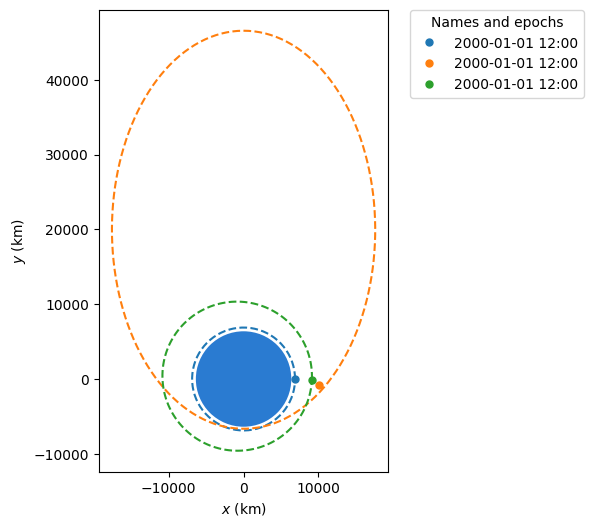

In [29]:
from astropy.time import Time

from matplotlib import pyplot as plt

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya

#Need lambert solver

epoch = Time("2018-08-17 12:05:50", scale="tdb")

# plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
# print(StaticOrbitPlotter)
# plotter.plot_body_orbit(Earth, epoch, label="Earth")
# plotter.plot_body_orbit(Mars, epoch, label="Mars")
ss_leo = Orbit.circular(Earth,alt=500*u.km)

a = 10000<< u.km
ecc = 0.093315 << u.one
inc = 0 << u.deg
raan = 49.562 << u.deg
argp = 286.537 << u.deg
nu = 23.33 << u.deg

ss_elliptic = Orbit.from_classical(Earth,a,ecc,inc,raan,argp,nu)
ss_molniya = Orbit.from_classical(Earth,molniya.a,molniya.ecc,molniya.inc,molniya.raan,molniya.argp,molniya.nu)

print(ss_leo)
print(molniya)
plotter = StaticOrbitPlotter(plane = Planes.EARTH_EQUATOR)
plotter.set_attractor(Earth)
plotter.plot(ss_leo)
ss_molniya.inc=0 << u.deg
plotter.plot(ss_molniya)
plotter.plot(ss_elliptic)


# # # Plotting
# plotter = OrbitPlotter2D()
# # plotter.plot(ss_leo, label="LEO")
# # plotter.plot(molniya, label="Molniya")
# plt.show()



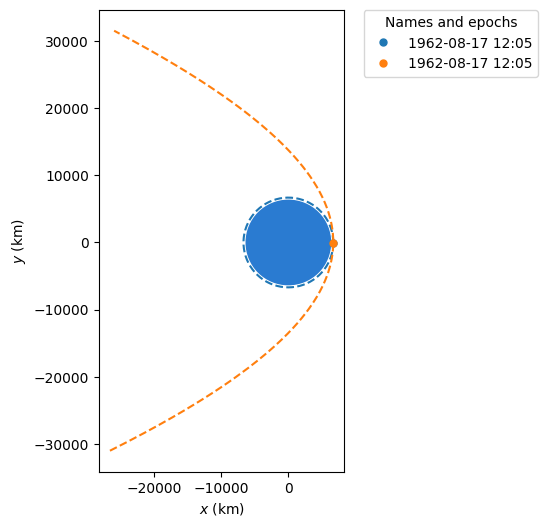

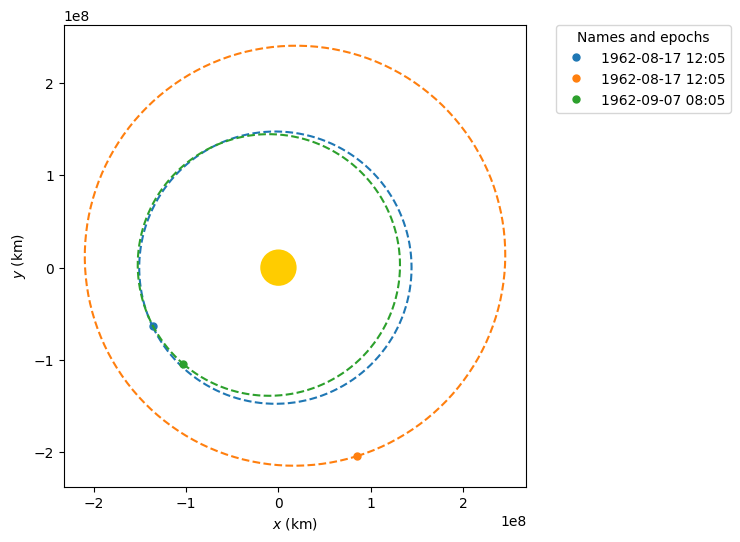

In [97]:
from astropy.time import Time
import numpy as np
from matplotlib import pyplot as plt

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range



a = Earth.R + 300*u.km
ecc = 0 << u.one
inc = 0 << u.deg
raan = 49.562 << u.deg
argp = 286.537 << u.deg
nu = 23.33 << u.deg

epoch1 = Time("2018-08-17 12:05:50", scale="tdb")
epoch2 = Time("1962-08-17 12:05:50", scale="tdb")
epoch3 = Time("1964-08-17 12:05:50", scale="tdb")

soiEscapeTime = 500

##setting up basic parems
earth_ephem = Ephem.from_body(Earth, time_range(epoch2, end=epoch3))
ss_earth = Orbit.from_ephem(Sun, earth_ephem, epoch2)
mars_ephem = Ephem.from_body(Mars, time_range(epoch2, end=epoch3))
ss_mars = Orbit.from_ephem(Sun, mars_ephem, epoch2)



ss_initial = Orbit.from_classical(Earth,a,ecc,inc,raan,argp,nu,epoch=epoch2)
##Now perform a burn

def returnPrograde(incOrb):
    prograde_v = incOrb.v / np.sqrt(np.sum(incOrb.v**2)).value << u.km/u.s
    return prograde_v

#loop until the orbit is an escape orbit, calculating how much to escape earth
dv = 0
man = Maneuver((0 * u.s, dv*returnPrograde(ss_initial)))
ss_final = ss_initial.apply_maneuver(man)
while(ss_final.ecc < (1*u.one)):
    dv=dv+0.1
    man = Maneuver((0 * u.s, dv*returnPrograde(ss_initial)))
    ss_final = ss_initial.apply_maneuver(man)
escapedv = dv
##Propogate this escape orbit to see what the velocity is at edge of earth SOI, which is 10^6km frm earth
soi_escape_earth = ss_final.propagate(soiEscapeTime << u.hour)
##need to find pos,velocity relative to sun at soi_escape_orb
###vel should just be earthVel + spaceCraftVel
ss_earth_soi_cross = ss_earth.propagate(soiEscapeTime << u.hour)
pos_spacecraft = ss_earth_soi_cross.r+soi_escape_earth.r
vel_spacecraft = ss_earth_soi_cross.v+soi_escape_earth.v
spacecraftSolarOrb = Orbit.from_vectors(Sun,pos_spacecraft,vel_spacecraft,epoch2+soiEscapeTime*u.hour)



##########Prob SHIT below
# speed_initial = np.sqrt(pow(ss_initial.v[0],2)+pow(ss_initial.v[1],2)+pow(ss_initial.v[2],2))
# prograde_v = (ss_initial.v/speed_initial) 
# print(prograde_v[0])

plotter = StaticOrbitPlotter(plane = Planes.EARTH_EQUATOR)
plotter.set_attractor(Earth)
plotter.plot(ss_initial)
plotter.plot(ss_final)

secondplotter = StaticOrbitPlotter()
secondplotter.set_attractor(Sun)
secondplotter.plot(ss_earth)
secondplotter.plot(ss_mars)
secondplotter.plot(spacecraftSolarOrb)




44381
(<Time object: scale='tdb' format='iso' value=1962-06-18 12:05:50.000>, <Time object: scale='tdb' format='iso' value=1962-08-27 12:05:50.000>)


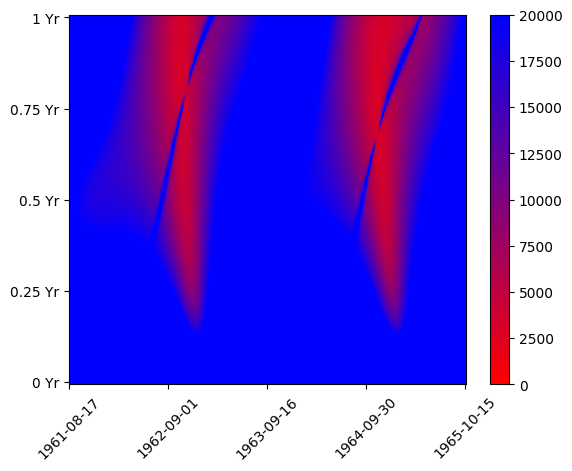

In [186]:
from astropy.time import Time, TimeDelta
import numpy as np

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates


epoch1 = Time("1961-08-17 12:05:50", scale="tdb")
epoch2 = Time("1965-10-17 12:05:50", scale="tdb")
epoch3 = Time("1966-11-17 12:05:50", scale="tdb")
MinTof = 0.1 << u.year
MaxTof = 1 << u.year
tejRes = 5 << u.day
tofRes = 5 << u.day

rows = int((epoch2-epoch1)/tejRes)
cols = int(365*u.day/tejRes)

maneuver_array = np.empty((rows, cols), dtype=object)
dv_array = np.empty((rows, cols), dtype=object)
date_array = np.empty((rows, cols), dtype=object)


##find the ephemeris of earth, mars at date of launch & at date of arrival
earth = Ephem.from_body(Earth, time_range(epoch1, end=epoch3))
mars = Ephem.from_body(Mars, time_range(epoch1, end=epoch3))


    ###Solve lambert for iterated TEJ, TOF
current_epoch = epoch1
for i in range(rows):
    current_epoch += tejRes
    #find the orbit of earth & mars at launch & landing
    # Solve for departure and target orbits
    ss_earth = Orbit.from_ephem(Sun, earth, current_epoch)
    currentTof = 0
    for j in range(cols):
        currentTof += tofRes 
        arrivalTime = current_epoch + currentTof
        ss_mars = Orbit.from_ephem(Sun, mars, arrivalTime)
        # Solve for the transfer maneuver 
        man_lambert = Maneuver.lambert(ss_earth, ss_mars)

        
        maneuver_array[i][j] = man_lambert[0]
        dv = np.linalg.norm(maneuver_array[i][j][1].value)
        dv_array[i][j] = int(dv)
        date_array[i][j] = current_epoch,arrivalTime
#print(date_array[20][58])

# Convert Astropy Time to Matplotlib dates
start_date = mdates.date2num(epoch1.to_datetime())
end_date = mdates.date2num(current_epoch.to_datetime())


# Convert to a float and replace None with 0 (or another default value) cause non solutions go null in that array
clean_data = np.nan_to_num(dv_array.astype(float)).transpose()


num_dates = 5
dates = np.linspace(start_date, end_date, num_dates)
date_labels = [mdates.num2date(date).strftime('%Y-%m-%d') for date in dates]
date_ticks = np.linspace(0, clean_data.shape[1] - 1, num_dates)
y_ticks = np.linspace(0, clean_data.shape[0] - 1, 5)  # 4 quarters + start of the year
y_labels = ['0 Yr', '0.25 Yr', '0.5 Yr', '0.75 Yr', '1 Yr']



# Define a custom colormap from blue to red for the porkchop plot
#TBA proper coloring scheme!
#
cmap = colors.LinearSegmentedColormap.from_list("red_to_blue", ["red", "blue"])


# Create the plot
#print(dv_array[20,30])
plt.imshow(clean_data, cmap=cmap, aspect='auto', vmin=0, vmax=20000,origin = 'lower')
# Set the x-ticks to correspond to the dates
plt.xticks(ticks=date_ticks, labels=date_labels, rotation=45)
plt.yticks(ticks=y_ticks, labels=y_labels)

print(dv_array[60][13])
print(date_array[60][13])


# Add a colorbar to show the mapping from data values to colors
plt.colorbar()

# Show the plot
plt.show()



<class 'numpy.ndarray'>


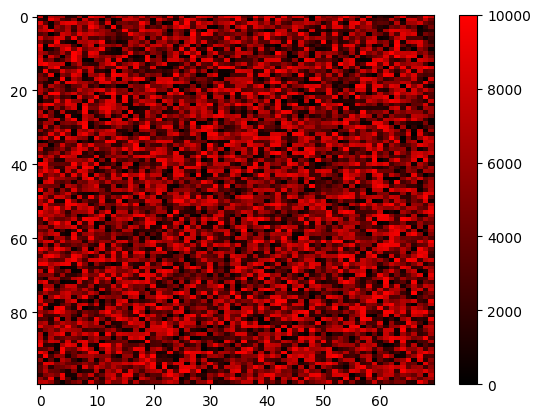

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Create a sample 2D array (100x70)
data = np.random.randint(0, 10001, (100, 70))
print(type(data))
# Define a custom colormap from black to red
cmap = colors.LinearSegmentedColormap.from_list("black_to_red", ["black", "red"])

# Create the plot
plt.imshow(data, cmap=cmap, aspect='auto')

# Add a colorbar to show the mapping from data values to colors
plt.colorbar()

# Show the plot
plt.show()

orbital decay seen after 0.030218458339349993 days


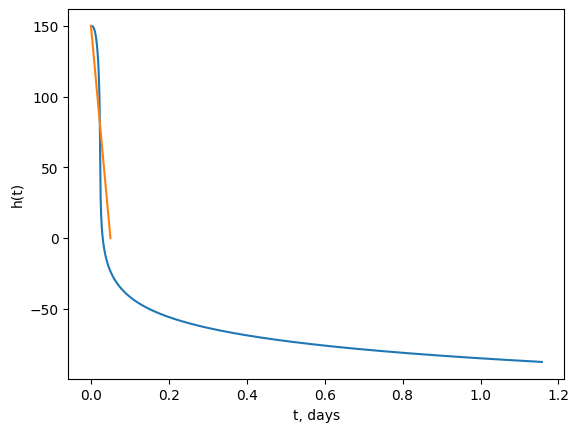

In [15]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"
from poliastro.twobody.events import LithobrakeEvent

R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value

alt = 150

orbit = Orbit.circular(
    Earth, alt * u.km, epoch=Time(0.0, format="jd", scale="tdb")
)

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A_over_m = ((np.pi / 4.0) * (u.m**2) / (100 * u.kg)).to_value(
    u.km**2 / u.kg
)  # km^2/kg
B = C_D * A_over_m

# parameters of the atmosphere
rho0 = rho0_earth.to(u.kg / u.km**3).value  # kg/km^3
H0 = H0_earth.to(u.km).value

tofs = TimeDelta(np.linspace(0 * u.h, 100000 * u.s, num=2000))


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = atmospheric_drag_exponential(
        t0,
        state,
        k,
        R=R,
        C_D=C_D,
        A_over_m=A_over_m,
        H0=H0,
        rho0=rho0,
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


rr, _ = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f)),
).rv()

plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, norm(rr, axis=1) - Earth.R)


orbit = Orbit.circular(
    Earth, alt * u.km, epoch=Time(0.0, format="jd", scale="tdb")
)
tofs = TimeDelta(np.linspace(0 * u.h, 100 * u.d, num=2000))

lithobrake_event = LithobrakeEvent(R)
events = [lithobrake_event]

rr, _ = orbit.to_ephem(
    EpochsArray(
        orbit.epoch + tofs, method=CowellPropagator(f=f, events=events)
    ),
).rv()

print(
    "orbital decay seen after", lithobrake_event.last_t.to(u.d).value, "days"
)
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs[: len(rr)].value, norm(rr, axis=1) - Earth.R)